In [1]:
import numpy as np
import trimesh
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
import open3d as o3d
import time
import sys,os
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 1

C:\Users\1\AppData\Local\Temp\ipykernel_15484\3355214197.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def color_mesh_by_curvature(mesh, curvatures, cmap= cm.get_cmap('jet')):


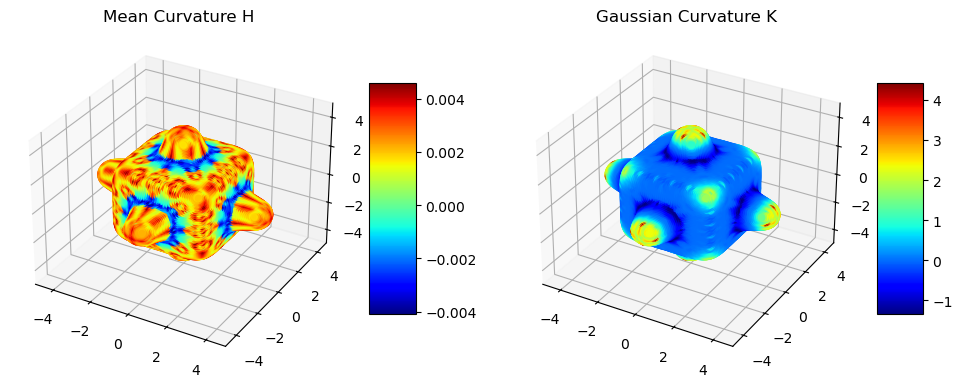

Mean Curvature H: [0.00104645 0.00256149 0.00256149 ... 0.00166876 0.00265517 0.00241607]
Gaussian Curvature K: [ 1.10985307 -0.11453097 -0.11453097 ... -0.51860664 -0.37859726
 -0.61227475]


In [2]:
RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# load mesh, vertices and faces
mesh = trimesh.load(mesh_src)
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)


# get neighbours for every vertex
def get_vertex_neighbors(faces):
    vertex_neighbors = {}
    for face in faces:
        for i in range(3):
            if face[i] not in vertex_neighbors:
                vertex_neighbors[face[i]] = []
            # add the other two vertices of the triangle as neighbors of the current vertex
            vertex_neighbors[face[i]].extend(list(face[:i]) + list(face[i+1:]))

    # delete repeat neighbours
    for vertex in vertex_neighbors: 
        vertex_neighbors[vertex] = list(set(vertex_neighbors[vertex]))
    return vertex_neighbors

# compute mean curvature H for each vertex
def compute_mean_curvature(vertices, vertex_neighbors, normals):
    H = np.zeros(len(vertices))
    for i in range(len(vertices)):
        if i not in vertex_neighbors: continue
        neighbor_vectors = vertices[vertex_neighbors[i]] - vertices[i]
        L = np.sum(neighbor_vectors, axis=0) / len(neighbor_vectors)
        H[i] = -np.linalg.norm(L) / 2
        if(np.dot(L, normals[i]) < 0):
            H[i] = -H[i]

    return H

# use Heron's formula to calculate the area of a triangle given the coordinates of its three vertices
def triangle_area(vertex1, vertex2, vertex3):
    # edge length
    a = np.linalg.norm(vertex1 - vertex2)
    b = np.linalg.norm(vertex2 - vertex3)
    c = np.linalg.norm(vertex3 - vertex1)
    
    # half perimeter
    s = (a + b + c) / 2
    
    # compute area
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

# 肉眼观察法这个应该算对了？
# https://blog.csdn.net/yinhun2012/article/details/112719305
def calculate_triangle_out_circle_center(A, B, C):
    # Convert input lists to NumPy arrays if they aren't already
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)

    # Calculate the vectors representing the sides of the triangle
    AB = B - A
    AC = C - A
    
    # Calculate the normal vector of the plane defined by the triangle
    AN = np.cross(AB, AC)
    AN = AN / np.linalg.norm(AN)  # Normalize the vector

    # Use the normal vector (AN) and point A to define the plane
    d = np.dot(AN, A)

    # Calculate the coefficients of the linear system
    e, f, g = C - A
    h = np.dot(C - A, (C + A) / 2)
    k, l, m = 2 * (B - A)
    n = np.dot(B, B) - np.dot(A, A)

    # Solve the linear system
    A_matrix = np.array([[AN[0], AN[1], AN[2]], [e, f, g], [k, l, m]])
    B_vector = np.array([d, h, n])
    P = np.linalg.solve(A_matrix, B_vector)
    # print(P, A, B, C)
    return P  # Convert the result to list if needed


# Helper function to check if a triangle is obtuse
def is_obtuse_triangle(A, B, C):
    # Check if a triangle is obtuse by comparing the squares of its sides
    a2 = np.linalg.norm(C - B)**2
    b2 = np.linalg.norm(C - A)**2
    c2 = np.linalg.norm(B - A)**2
    return a2 + b2 < c2 or a2 + c2 < b2 or b2 + c2 < a2

# Function to calculate mixed cell Gaussian curvature
def mixed_cells_gaussian_curvature(vertices, faces):
    # Initialize area and angle deficit for each vertex
    voronoi_areas = np.zeros(len(vertices))
    angle_deficits = 2 * np.pi * np.ones(len(vertices))

    # Calculate the Voronoi area and angle deficit for each vertex
    for face in faces:
        A, B, C = vertices[face]
        # Check if the triangle is obtuse
        is_obtuse = is_obtuse_triangle(A, B, C)

        # Compute the circumcenter for non-obtuse triangles
        if not is_obtuse:
            circum_center = calculate_triangle_out_circle_center(A, B, C)

        # Calculate Voronoi area for each vertex in the face
        for i, vertex in enumerate(face):
            opposite_edge = np.delete(face, i)

            if is_obtuse or  circum_center is None:
                # For obtuse triangle, use midpoint of the edge opposite the obtuse angle
                voronoi_areas[vertex] += triangle_area(vertices[vertex], (vertices[opposite_edge[0]] + vertices[opposite_edge[1]]) / 2, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], (vertices[opposite_edge[0]] + vertices[opposite_edge[1]]) / 2, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
            else:
                # For non-obtuse triangle, use circumcenter
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
                voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
                                                       (vertices[vertex] + vertices[opposite_edge[1]]) / 2)

            # Compute the angle at vertex
            vec1, vec2 = vertices[opposite_edge[0]] - vertices[vertex], vertices[opposite_edge[1]] - vertices[vertex]
            angle = np.arccos(np.clip(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)), -1, 1))
            angle_deficits[vertex] -= angle

            # voronoi_areas[vertex] += triangle_area(A, B, C) / 3

    # Compute Gaussian curvature
    gaussian_curvature = angle_deficits / voronoi_areas
    gaussian_curvature[np.isnan(gaussian_curvature)] = 0  # Handle NaN values

    return gaussian_curvature


def color_mesh_by_curvature(mesh, curvatures, cmap= cm.get_cmap('jet')):
    # Normalize the curvature values to [0, 1] for colormap mapping
    curvatures_normalized = (curvatures - np.min(curvatures)) / (np.max(curvatures) - np.min(curvatures))
    
    # Map the normalized curvature values to a colormap
    colors = cmap(curvatures_normalized)
    
    # Update the vertex colors of the mesh
    mesh.visual.vertex_colors = (colors[:, :3] * 255).astype(np.uint8)

    return mesh

# 可视化曲率
def visualize_curvature(mesh, vertices, H, K):
    fig = plt.figure(figsize=(12, 6))

    # 可视化均质曲率H
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Mean Curvature H")
    scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H, cmap='jet')
    fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
    coloured_mesh = color_mesh_by_curvature(mesh, H)
    coloured_mesh.export("mean_curvature.ply")

    # 可视化高斯曲率K
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Gaussian Curvature K")
    scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=K, cmap='jet')
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)
    coloured_mesh = color_mesh_by_curvature(mesh, K)
    coloured_mesh.export("gaussian_curvature.ply")

    plt.show()


# 获取每个顶点的邻居3q
vertex_neighbors = get_vertex_neighbors(faces)
# 计算均质曲率H和高斯曲率K
H = compute_mean_curvature(vertices, vertex_neighbors, normals)
K = mixed_cells_gaussian_curvature(vertices, faces)

visualize_curvature(mesh, vertices, H, K)
# 输出结果（这里只是打印出来，您可能需要将它们保存到文件或以其他方式处理）
print("Mean Curvature H:", H)
print("Gaussian Curvature K:", K)


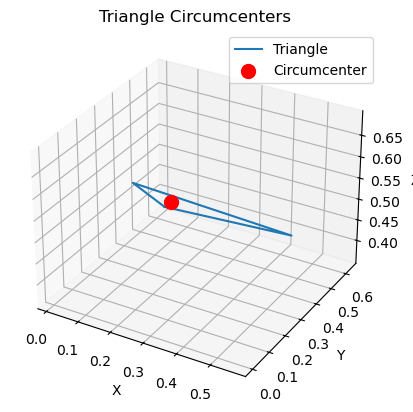

In [3]:
# 检查外心函数到底写得对不对

# 生成随机的三角形
num_triangles = 1
triangles = []
is_obtuse = True
for _ in range(num_triangles):
    while is_obtuse:
        A = np.random.rand(3)  # 随机生成点 A
        B = np.random.rand(3)  # 随机生成点 B
        C = np.random.rand(3)  # 随机生成点 C
        is_obtuse = is_obtuse_triangle(A, B, C)
    triangles.append((A, B, C))

# 计算每个三角形的外心
circumcenters = []
for triangle in triangles:
    circum_center = calculate_triangle_out_circle_center(A, B, C)
    circumcenters.append(circum_center)

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for triangle, circumcenter in zip(triangles, circumcenters):
    A, B, C = triangle
    ax.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], [A[2], B[2], C[2], A[2]], label='Triangle')
    ax.scatter(circumcenter[0], circumcenter[1], circumcenter[2], color='red', s=100, label='Circumcenter')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangle Circumcenters')
ax.legend()

plt.show()


### 2

In [4]:
import numpy as np

# Function to compute the first and second fundamental forms
# 检查过了理解了
def fundamental_forms(a, b, c, u, v):
    # First, we define the parametric surface function for the ellipsoid
    def ellipsoid(u, v):
        return np.array([a * np.cos(u) * np.sin(v), 
                         b * np.sin(u) * np.sin(v), 
                         c * np.cos(v)])
    
    # Compute the partial derivatives for the tangent vectors
    def partial_u(u, v):
        return np.array([-a * np.sin(u) * np.sin(v), 
                          b * np.cos(u) * np.sin(v), 
                          0])
    
    def partial_v(u, v):
        return np.array([a * np.cos(u) * np.cos(v), 
                         b * np.sin(u) * np.cos(v), 
                        -c * np.sin(v)])
    
    # Compute the normal vector by taking the cross product of the partial derivatives
    def normal_vector(u, v):
        return np.cross(partial_u(u, v), partial_v(u, v))
    
    # Normalize the normal vector
    def unit_normal(u, v):
        n = normal_vector(u, v)
        return n / np.linalg.norm(n)
    
    # Compute the second derivatives
    def second_partial_uu(u, v):
        return np.array([-a * np.cos(u) * np.sin(v), 
                         -b * np.sin(u) * np.sin(v), 
                          0])
    
    def second_partial_uv(u, v):
        return np.array([-a * np.sin(u) * np.cos(v), 
                          b * np.cos(u) * np.cos(v), 
                         0])
    
    def second_partial_vv(u, v):
        return np.array([-a * np.cos(u) * np.sin(v), 
                         -b * np.sin(u) * np.sin(v), 
                         -c * np.cos(v)])
    
    # Compute the coefficients of the first fundamental form
    E = np.dot(partial_u(u, v), partial_u(u, v))
    F = np.dot(partial_u(u, v), partial_v(u, v))
    G = np.dot(partial_v(u, v), partial_v(u, v))
    
    # Compute the coefficients of the second fundamental form
    L = np.dot(second_partial_uu(u, v), unit_normal(u, v))
    M = np.dot(second_partial_uv(u, v), unit_normal(u, v))
    N = np.dot(second_partial_vv(u, v), unit_normal(u, v))
    
    return (E, F, G), (L, M, N)

# 还是不理解这里的du和dv是啥意思，为啥这么取
# Function to compute the normal curvature
def normal_curvature(a, b, c, direction_vector):
    # At the point (a,0,0), u = 0 and v = pi/2
    u = 0
    v = np.pi / 2
    
    # Compute the first and second fundamental forms at (a,0,0)
    (E, F, G), (L, M, N) = fundamental_forms(a, b, c, u, v)
    
    # Compute the normal curvature using the formula
    # k_n = (Ldu^2 + 2Mdu*dv + Ndv^2) / (Edu^2 + 2Fdu*dv + Gdv^2)
    # For direction vector (du, dv), normalize it first
    # 在该点的局部切平面上的方向向量 (du,dv)。由于这个点在椭球的赤道上，我们可以简单地取 du 和 dv 来代表赤道方向和极点方向
    du, dv = direction_vector
    magnitude = np.sqrt(du**2 + dv**2)
    du, dv = du / magnitude, dv / magnitude
    
    numerator = L*du**2 + 2*M*du*dv + N*dv**2
    denominator = E*du**2 + 2*F*du*dv + G*dv**2
    k_n = numerator / denominator
    
    return k_n

# For example, a ellipsoid
a, b, c = 1, 2, 3
# Example direction, could be any vector on the tangent plane
direction_vector = (1, 0)

# Compute the normal curvature at (a,0,0) in the given direction
k_n = normal_curvature(a, b, c, direction_vector)
k_n


0.25

### 3

In [74]:
# Function to calculate the midpoint of an edge
def edge_midpoint(v1, v2):
    return (v1 + v2) / 2

# Function to calculate the centroid of a triangle
def triangle_centroid(v1, v2, v3):
    return (v1 + v2 + v3) / 3

def CentroidArea(vertices, faces):
    # Initialize an array to hold the sum of the barycentric areas for each vertex
    vertex_areas = np.zeros(len(vertices))
    
    for face in faces:
        # Gather the vertices for the current triangle face
        v1, v2, v3 = [vertices[face[i]] for i in range(3)]
        
        # Calculate the area of the triangle using trimesh
        triangle_vertices = np.array([v1, v2, v3])
        triangle_area = trimesh.triangles.area([triangle_vertices])[0]

        # Add 1/3 of the triangle's area to each of the triangle's vertices
        for i in range(3):
            vertex_areas[face[i]] += triangle_area / 3

    return vertex_areas

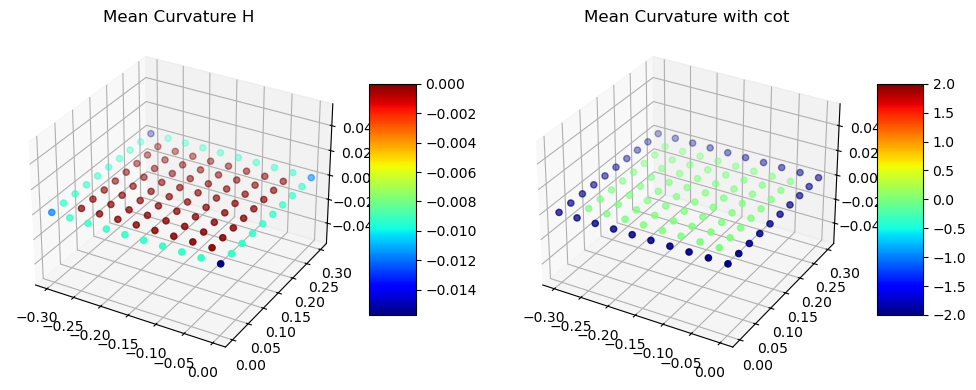

In [106]:
RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

def calculate_cotangent(p1, p2, p3):
    # 计算两边向量
    edge1, edge2 = p1 - p3, p2 - p3
    # 使用稳定的方法计算余切值
    dot_product = np.dot(edge1, edge2)
    cross_product_norm = np.linalg.norm(np.cross(edge1, edge2))
    # 防止除以零
    if cross_product_norm == 0:
        return 0
    return dot_product / cross_product_norm


# 函数计算每个顶点的邻居和对边角的余切和面积
def get_vertex_neighbors_and_cotangent(faces, vertices):
    # 初始化邻居和余切权重字典
    vertex_neighbors = {i: set() for i in range(len(vertices))}
    cotangent_weights = {i: {} for i in range(len(vertices))}
    # voronoi_areas = np.zeros(len(vertices))

    # 对于每个面，找到共享边的三角形
    for face in faces:
        A, B, C = vertices[face]
        is_obtuse = is_obtuse_triangle(A, B, C)
        if not is_obtuse:
            circum_center = calculate_triangle_out_circle_center(A, B, C)

        # Calculate Voronoi area for each vertex in the face
        # for i, vertex in enumerate(face):
        #     opposite_edge = np.delete(face, i)

        #     if is_obtuse or  circum_center is None:
        #         # For obtuse triangle, use midpoint of the edge opposite the obtuse angle
        #         voronoi_areas[vertex] += triangle_area(vertices[vertex], np.mean(vertices[opposite_edge], axis=0), 
        #                                                (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
        #         voronoi_areas[vertex] += triangle_area(vertices[vertex], np.mean(vertices[opposite_edge], axis=0), 
        #                                                (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
        #     else:
        #         # For non-obtuse triangle, use circumcenter
        #         voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
        #                                                (vertices[vertex] + vertices[opposite_edge[0]]) / 2)
        #         voronoi_areas[vertex] += triangle_area(vertices[vertex], circum_center, 
        #                                                (vertices[vertex] + vertices[opposite_edge[1]]) / 2)
        # print(voronoi_areas[vertex])
        # 对于面中的每个顶点
        for i in range(3):
            # 顶点索引
            v1, v2, v3 = face[i], face[(i + 1) % 3], face[(i + 2) % 3]
            # 顶点坐标
            p1, p2, p3 = vertices[v1], vertices[v2], vertices[v3]
            # 边向量
            edge1, edge2 = p1 - p3, p2 - p3
            # 对边角的余切
            cotangent1 = np.dot(edge1, edge2) / np.linalg.norm(np.cross(edge1, edge2))
            edge1, edge2 = p1 - p2, p3 - p2
            cotangent2 = np.dot(edge1, edge2) / np.linalg.norm(np.cross(edge1, edge2))
            
            # 更新邻居和余切权重
            vertex_neighbors[v1].add(v2)
            vertex_neighbors[v1].add(v3)
            if v2 not in cotangent_weights[v1]:
                cotangent_weights[v1][v2] = 0
            if v3 not in cotangent_weights[v1]:
                cotangent_weights[v1][v3] = 0
            cotangent_weights[v1][v2] += cotangent1
            cotangent_weights[v1][v3] += cotangent2

    # every angle cot is counted twice
    cotangent_weights = {vertex: {neigh: weight / 2 for neigh, weight in neigh_weights.items()} 
                     for vertex, neigh_weights in cotangent_weights.items()}
    
    # 删除重复项并计算最终的余切权重
    for vertex in vertex_neighbors:
        vertex_neighbors[vertex] = list(vertex_neighbors[vertex])
        weights = np.array([cotangent_weights[vertex][neigh] for neigh in vertex_neighbors[vertex]])
        # print(vertex_neighbors[vertex])
        # print(weights)
        cotangent_weights[vertex] = weights
    voronoi_areas = CentroidArea(vertices, faces)
    return vertex_neighbors, cotangent_weights, voronoi_areas


# 计算每个顶点的均值曲率H使用余切权重
def compute_mean_curvature_with_cotangent(vertices, vertex_neighbors, cotangent_weights, normals, voronoi_areas):
    H = np.zeros(len(vertices))
    for i in range(len(vertices)):
        if i not in vertex_neighbors: continue
        neighbor_vectors = vertices[vertex_neighbors[i]] - vertices[i]
        weights = np.array(cotangent_weights[i])  # 确保weights是一个numpy数组
        L = np.sum(neighbor_vectors * weights[:, np.newaxis], axis=0) / (2 * voronoi_areas[i])
        # H[i] = - np.dot(L, normals[i]) / 2
        H[i] = -np.linalg.norm(L) / 2
        if(np.dot(L, normals[i]) < 0):
            H[i] = -H[i]
    return H

# 可视化曲率
def visualize_curvature(mesh, vertices, H1, H2):
    fig = plt.figure(figsize=(12, 6))

    # 可视化均质曲率H
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Mean Curvature H")
    scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H1, cmap='jet')
    fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
    coloured_mesh = color_mesh_by_curvature(mesh, H1)
    coloured_mesh.export("h1.ply")

    # 可视化高斯曲率K
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Mean Curvature with cot")
    scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H2, cmap='jet', vmin=-2, vmax=2)
    # scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H2, cmap='jet')
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)
    coloured_mesh = color_mesh_by_curvature(mesh, H2)
    coloured_mesh.export("h2.ply")

    plt.show()

# 获取每个顶点的邻居和余切权重
vertex_neighbors, cotangent_weights, voronoi_areas = get_vertex_neighbors_and_cotangent(faces, vertices)
# 计算均值曲率H使用余切离散化
H2 = compute_mean_curvature_with_cotangent(vertices, vertex_neighbors, cotangent_weights, normals, voronoi_areas)
H1 = compute_mean_curvature(vertices, vertex_neighbors, normals)

visualize_curvature(mesh, vertices, H1, H2)


### 4

##### chatgpt乱写的代码，结果比我认真写半天的ppt结果还好，nm啊

In [46]:
from scipy.sparse import csr_matrix


# Function to compute the cotangent Laplace-Beltrami operator for the mesh
def compute_laplacian(vertices, faces):
    # Number of vertices
    n = len(vertices)

    # Initialize weights and matrix indices
    I = []
    J = []
    W = []

    # Iterate over faces to compute cotangent weights
    for face in faces:
        for i in range(3):
            j = (i + 1) % 3
            k = (i + 2) % 3
            vi = vertices[face[i]]
            vj = vertices[face[j]]
            vk = vertices[face[k]]
            # Compute cotangents for edges (i, j) and (i, k)
            cot_ij = np.dot(vj - vk, vi - vk) / np.linalg.norm(np.cross(vj - vk, vi - vk))
            cot_ik = np.dot(vj - vi, vj - vk) / np.linalg.norm(np.cross(vj - vi, vj - vk))
            # Append data for the sparse matrix
            I.append(face[i])
            J.append(face[j])
            W.append(cot_ij / 2.0)
            I.append(face[i])
            J.append(face[k])
            W.append(cot_ik / 2.0)

    # Create the sparse matrix
    L = csr_matrix((W, (I, J)), shape=(n, n))
    # Make it symmetric
    L = L + L.T

    # Set the diagonal
    L.setdiag(-np.array(L.sum(axis=1)).flatten())

    return L

#### 照ppt写的代码，应该没错吧啊啊啊啊啊

In [92]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
import scipy.sparse as sp

RES_PATH = 'meshes'
mesh_src = os.path.join(RES_PATH, 'decomposition/armadillo.obj')
# mesh_src = os.path.join(RES_PATH, 'decomposition/cow_small_manifold2.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/plane.obj')
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src
# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

def construct_laplacian(vertex_neighbors, cotangent_weights, voronoi_areas):
    n = len(vertices)
    I = []
    J = []
    C_entries = []
    M_inv_entries = []

    for i in range(n):
        M_inv_entries.append(1.0 / (2.0 * voronoi_areas[i]))
        row_sum = 0
        for j in vertex_neighbors[i]:
            cot_weight = cotangent_weights[i][vertex_neighbors[i].index(j)]
            I.append(i)
            J.append(j)
            C_entries.append(cot_weight)
            row_sum += cot_weight

        I.append(i)
        J.append(i)
        C_entries.append(-row_sum)

    C = sp.csr_matrix((C_entries, (I, J)), shape=(n, n))
    M_inv = sp.diags(M_inv_entries)

    L = M_inv @ C
    # L = L + L.T
    # L = L + sp.eye(n) * 1e-5
    return L


# Function to perform the mesh reconstruction using the smallest k eigenvectors
def mesh_reconstruction(vertices, faces, normals, k_values):
    # Get vertex neighbors and cotangent weights
    vertex_neighbors, cotangent_weights, voronoi_areas = get_vertex_neighbors_and_cotangent(faces, vertices)
    
    # Construct the Laplacian matrix
    n_vertices = len(vertices)
    L = construct_laplacian(vertex_neighbors, cotangent_weights, voronoi_areas)
    # L = compute_laplacian(vertices, faces)
    
    # Perform eigen decomposition and reconstruct the mesh for each k
    reconstructions = {}
    for k in k_values:
        eigenvalues, eigenvectors = eigsh(L, k + 1, which='SM', tol=1e-4, maxiter=10000)
        eigenvectors = eigenvectors[:, 1:k+1]
        reconstruction = eigenvectors @ eigenvectors.T @ vertices
        reconstructions[k] = reconstruction

    return reconstructions


# Perform the reconstructions for k = 5, 15, 50
k_values = [50]
reconstructions = mesh_reconstruction(vertices, faces, normals, k_values)

# Save the reconstructed meshes and provide file paths
output_files = {}
for k, recon_verts in reconstructions.items():
    # Create a new mesh with the reconstructed vertices
    recon_mesh = trimesh.Trimesh(vertices=recon_verts, faces=faces, process=False)
    recon_mesh.export(f'armadillo_reconstructed_k{k}.obj')

output_files


KeyboardInterrupt: 

## Smootihng

#### 5

In [110]:
def construct_laplacian(vertex_neighbors, cotangent_weights, voronoi_areas):
    n = len(vertices)
    I = []
    J = []
    C_entries = []
    M_inv_entries = []

    for i in range(n):
        M_inv_entries.append(1.0 / (2.0 * voronoi_areas[i]))
        row_sum = 0
        for j in vertex_neighbors[i]:
            cot_weight = cotangent_weights[i][vertex_neighbors[i].index(j)]
            I.append(i)
            J.append(j)
            C_entries.append(cot_weight)
            row_sum += cot_weight

        I.append(i)
        J.append(i)
        C_entries.append(-row_sum)

    C = sp.csr_matrix((C_entries, (I, J)), shape=(n, n))
    M_inv = sp.diags(M_inv_entries)

    L = M_inv @ C

    return L

def CentroidArea(vertices, faces):
    # Initialize an array to hold the sum of the barycentric areas for each vertex
    vertex_areas = np.zeros(len(vertices))
    
    for face in faces:
        # Gather the vertices for the current triangle face
        v1, v2, v3 = [vertices[face[i]] for i in range(3)]
        
        # Calculate the area of the triangle using trimesh
        triangle_vertices = np.array([v1, v2, v3])
        triangle_area = trimesh.triangles.area([triangle_vertices])[0]

        # Add 1/3 of the triangle's area to each of the triangle's vertices
        for i in range(3):
            vertex_areas[face[i]] += triangle_area / 3

    return vertex_areas

In [111]:
RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
# mesh_src = os.path.join(RES_PATH, 'cube.obj')
mesh_src = os.path.join(RES_PATH, 'smoothing/fandisk_ns.obj')
# mesh_src = os.path.join(RES_PATH, 'smoothing/plane_ns.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

def calculate_cotangent(p1, p2, p3):
    # 计算两边向量
    edge1, edge2 = p1 - p3, p2 - p3
    # 使用稳定的方法计算余切值
    dot_product = np.dot(edge1, edge2)
    cross_product_norm = np.linalg.norm(np.cross(edge1, edge2))
    # 防止除以零
    if cross_product_norm == 0:
        return 0
    return dot_product / cross_product_norm

def explicit_smoothing(vertices, faces, lambda_value, iterations=50):
    # Compute the Laplacian and inverse mass matrix
    # L = compute_laplacian(vertices, faces)
    vertex_neighbors, cotangent_weights, voronoi_areas= get_vertex_neighbors_and_cotangent(faces, vertices)
    voronoi_areas = CentroidArea(vertices, faces)
    L = construct_laplacian(vertex_neighbors, cotangent_weights, voronoi_areas)
    I = sp.eye(vertices.shape[0])
    # Perform the smoothing operation
    for _ in range(iterations):
        # Update vertex positions
        vertices = (I + lambda_value * L).dot(vertices)
    return vertices

# Set lambda_value (step size) for smoothing
lambda_value = 0.05  # Smaller value to avoid excessive smoothing

# Perform explicit smoothing
smoothed_vertices = explicit_smoothing(vertices, faces, lambda_value)

# Save the reconstructed meshes and provide file paths
smoothed_mesh = trimesh.Trimesh(vertices=smoothed_vertices, faces=faces, process=False)
smoothed_mesh.export(f'smoothed_obj_exp.obj')


'# https://github.com/mikedh/trimesh\nv 3907093116504265918047929436521333506417234538310304674085137447322448558030848.00000000 4979620187820498003661129605964552094612230883868556689199597015109786826440704.00000000 9505785168246603295695459996103171998841935649722443732097314192684855819501568.00000000\nv 27156443800109484820999433338569010266153737111274560336137302861961032974606239006720.00000000 1260274783134048066370004950924841949105914186646401667630549749802008099437676593152.00000000 1826185512201960579785760768546837892637605099164986187220447194712902805421966753792.00000000\nv -249248582773947172560862414135408799424286350251562567338458541277547305643155593887744.00000000 84922877620456898084734101586347533123134366775656956993315252792300991569242204667904.00000000 -211431224924681450982528235485693144759775345191612546621607995243834575206837664088064.00000000\nv 309644422278914445710418665489974854748000676192215762796638198779543701525440267026432.00000000 -10545743

#### 6

In [9]:
from scipy.sparse.linalg import spsolve

RES_PATH = 'meshes'
# mesh_src = os.path.join(RES_PATH, 'curvatures/lilium_s.obj')
# mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
mesh_src = os.path.join(RES_PATH, 'smoothing/fandisk_ns.obj')
# mesh_src = os.path.join(RES_PATH, 'smoothing/plane_ns.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src

# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
normals = np.asarray(mesh.vertex_normals)

def implicit_smoothing(vertices, faces, lambda_value, iterations=3):
    # Compute the Laplacian and inverse mass matrix
    L = construct_laplacian(vertices, faces)
    I = sp.eye(vertices.shape[0])
    # Perform the smoothing operation
    for _ in range(iterations):
        # Update vertex positions
        # vertices = np.linalg.inv(I - lambda_value * L).dot(vertices)
        A = I - lambda_value * L
        vertices = spsolve(A, vertices)
    return vertices

# Set lambda_value (step size) for smoothing
lambda_value = 0.05  # Smaller value to avoid excessive smoothing

# Perform explicit smoothing
smoothed_vertices = implicit_smoothing(vertices, faces, lambda_value)

# Save the reconstructed meshes and provide file paths
smoothed_mesh = trimesh.Trimesh(vertices=smoothed_vertices, faces=faces, process=False)
smoothed_mesh.export(f'smoothed_obj_imp.obj')


'# https://github.com/mikedh/trimesh\nv 1.93733405 14.13471092 -0.00740179\nv 0.01285560 15.36223905 -1.35526035\nv 2.18024249 16.65589078 -0.49588892\nv 2.24544355 16.71442865 -0.36504754\nv 2.22046908 16.68243352 -0.15784717\nv 2.31397175 16.76508999 -0.53563835\nv 0.17936590 15.36903845 -1.49494995\nv 4.66694351 13.59746049 -0.20001180\nv 2.33585630 16.79187037 -0.15853475\nv 0.02805870 15.39391129 -1.19595820\nv 2.44555573 16.90888562 -0.50059640\nv 3.50589898 16.73741970 -0.01878932\nv 0.14970623 15.36928954 -1.27486706\nv 2.44220855 16.90791243 -0.22911270\nv 2.55462707 17.01646588 -0.39927779\nv -0.00666948 15.40787946 -0.98205817\nv 2.54987132 17.00856458 -0.20827112\nv 0.01507753 15.38636211 -0.76687164\nv 4.74099548 13.62692992 -0.09909973\nv 0.00181690 15.42206998 -0.62654776\nv 2.70714935 17.12601141 -0.17690549\nv 0.04158354 15.39505981 -0.35879393\nv 2.68044624 17.10223476 -0.30754950\nv 0.02396874 15.41688923 -0.17551761\nv 2.78393248 17.18838039 -0.43150177\nv 0.0498715

In [20]:
# 初始化用于收集数据的列表
noise_levels_list = []
mean_differences = []

def add_noise_to_vertices(vertices, noise_level):
    noise = np.random.normal(0, noise_level, vertices.shape)
    vertices_noisy = vertices + noise
    return vertices_noisy

noise_levels = np.linspace(0, 0.1, 10)  # 从0到0.1的噪声水平
for i, noise_level in enumerate(noise_levels):
    vertices_noisy = add_noise_to_vertices(vertices, noise_level)
    
    # 假定 lambda_value 已经在某处定义
    lambda_value = 0.1  # 示例值，需要根据需要调整
    smoothed_vertices = implicit_smoothing(vertices_noisy, faces, lambda_value)
    
    original_mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals, process=False)
    noisy_mesh = trimesh.Trimesh(vertices=vertices_noisy, faces=faces, vertex_normals=normals, process=False)
    smoothed_mesh = trimesh.Trimesh(vertices=smoothed_vertices, faces=faces, vertex_normals=normals, process=False)

    difference = np.linalg.norm(vertices - smoothed_vertices, axis=1).mean()
    print(f"Noise Level: {noise_level}, Mean Difference: {difference}")

    # 保存每个噪声水平及其对应的平均差异
    noise_levels_list.append(noise_level)
    mean_differences.append(difference)

    ## 保存网格为 OBJ 文件
    original_mesh.export(f'77/original_mesh_{i}.obj')
    noisy_mesh.export(f'77/noisy_mesh_{i}.obj')
    smoothed_mesh.export(f'77/smoothed_mesh_{i}.obj')

# 绘制噪声水平与平均差异的关系图
plt.figure(figsize=(10, 6))
plt.plot(noise_levels_list, mean_differences, marker='o', linestyle='-')
plt.title('Noise Level vs. Mean Difference from Original Mesh')
plt.xlabel('Noise Level')
plt.ylabel('Mean Difference')
plt.grid(True)
plt.show()



Noise Level: 0.0, Mean Difference: 0.013631434901401394
Noise Level: 0.0, Mean Difference: 0.013631434901401394
Noise Level: 0.011111111111111112, Mean Difference: 0.02057337357164585
Noise Level: 0.011111111111111112, Mean Difference: 0.02057337357164585
Noise Level: 0.022222222222222223, Mean Difference: 0.031350821757637946
Noise Level: 0.022222222222222223, Mean Difference: 0.031350821757637946
Noise Level: 0.03333333333333333, Mean Difference: 0.04222667006650629
Noise Level: 0.03333333333333333, Mean Difference: 0.04222667006650629
Noise Level: 0.044444444444444446, Mean Difference: 0.05299079129750328
Noise Level: 0.044444444444444446, Mean Difference: 0.05299079129750328
Noise Level: 0.05555555555555556, Mean Difference: 0.06301977439987311
Noise Level: 0.05555555555555556, Mean Difference: 0.06301977439987311
Noise Level: 0.06666666666666667, Mean Difference: 0.07218449137950765
Noise Level: 0.06666666666666667, Mean Difference: 0.07218449137950765
Noise Level: 0.0777777777777